<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Overnight_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [286]:
!pip3 install pyfolio
import pyfolio as pyf

OVERNIGHT TRADING STRATEGY

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [287]:
!pip install datetime
import datetime

day = 3
month = 8
year = 2019
delta = 4

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"
#       Feasibility
# EREGL 2.26
# ASELS 1.53
# THYAO 0.34
# GARAN 0.78
# KCHOL 0.598
# ISDMR 1.5
# QUAGR 0.90
# CANTE 0.15
# EUPWR 0.59
# YKBNK 0.78
# DOAS  0.81
# INFO  0.34
# TUPRS 0.73

In [288]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# For data manupulations


# VF    LB    PEAK_CUM  CUM_LAST    REVERSED
# 0.25  45    6.11       4.29 OK    True
# 0.35  45    7.42       5.02 OK    True
# 0.40  45    7.64       5.17 OK    True
# 0.45  45    8.99       6.16 OK    True
# 0.45  45    1.22       1.05 OK    False
# 0.45  55    7.97       5.39 OK    True
# 0.45  40    9.35       6.31 OK    True
# 0.45  35    9.65       7.14 OK    True
# 0.45  33    9.78       7.24 OK    True  ***
# 0.45  32    10.02      7.42 OK    True  ****
# 0.45  30    9.16       6.78 OK    True
# 0.45  25    8.19       5.98 OK    True
# -   -       5.17       4.82 OK    True / original Gap up buy side.



# Read data from Yahoo finance

data = yf.download(TickerIS,START, END)

data_close = data['Adj Close']

data_rel = data['Adj Close'] / data['Adj Close'][0]

# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2023-07-27,37.799999,38.419998,37.799999,37.919998,37.919998,111668915,37.799999
2023-07-28,38.200001,38.720001,38.180000,38.459999,38.459999,133192659,38.200001
2023-07-31,38.759998,42.000000,38.759998,41.700001,41.700001,314351426,38.759998
2023-08-01,41.560001,42.200001,40.680000,40.759998,40.759998,197475026,41.560001
2023-08-02,40.759998,42.320000,40.580002,40.939999,40.939999,166375142,40.759998


In [289]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [290]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(R_WINDOW).std()

In [291]:
data['positions'] = np.nan

In [292]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [293]:
# IMPROVED STRATEGY

# Long entry condition
if REVERSED:
  long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
else:
# Short entry condition
  long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']


In [294]:
# Store 1 when long entry condition is true
data.loc[long_entry, 'positions'] = 1

# Store -1 when short entry condition is true
#data.loc[short_entry, 'positions'] = -1

# Store 0 when wait condition is true
data.loc[short_entry, 'positions'] = 0

data['positions'].fillna(method='ffill', inplace=True)

# Drop NaN values
#data = data.dropna()

In [295]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

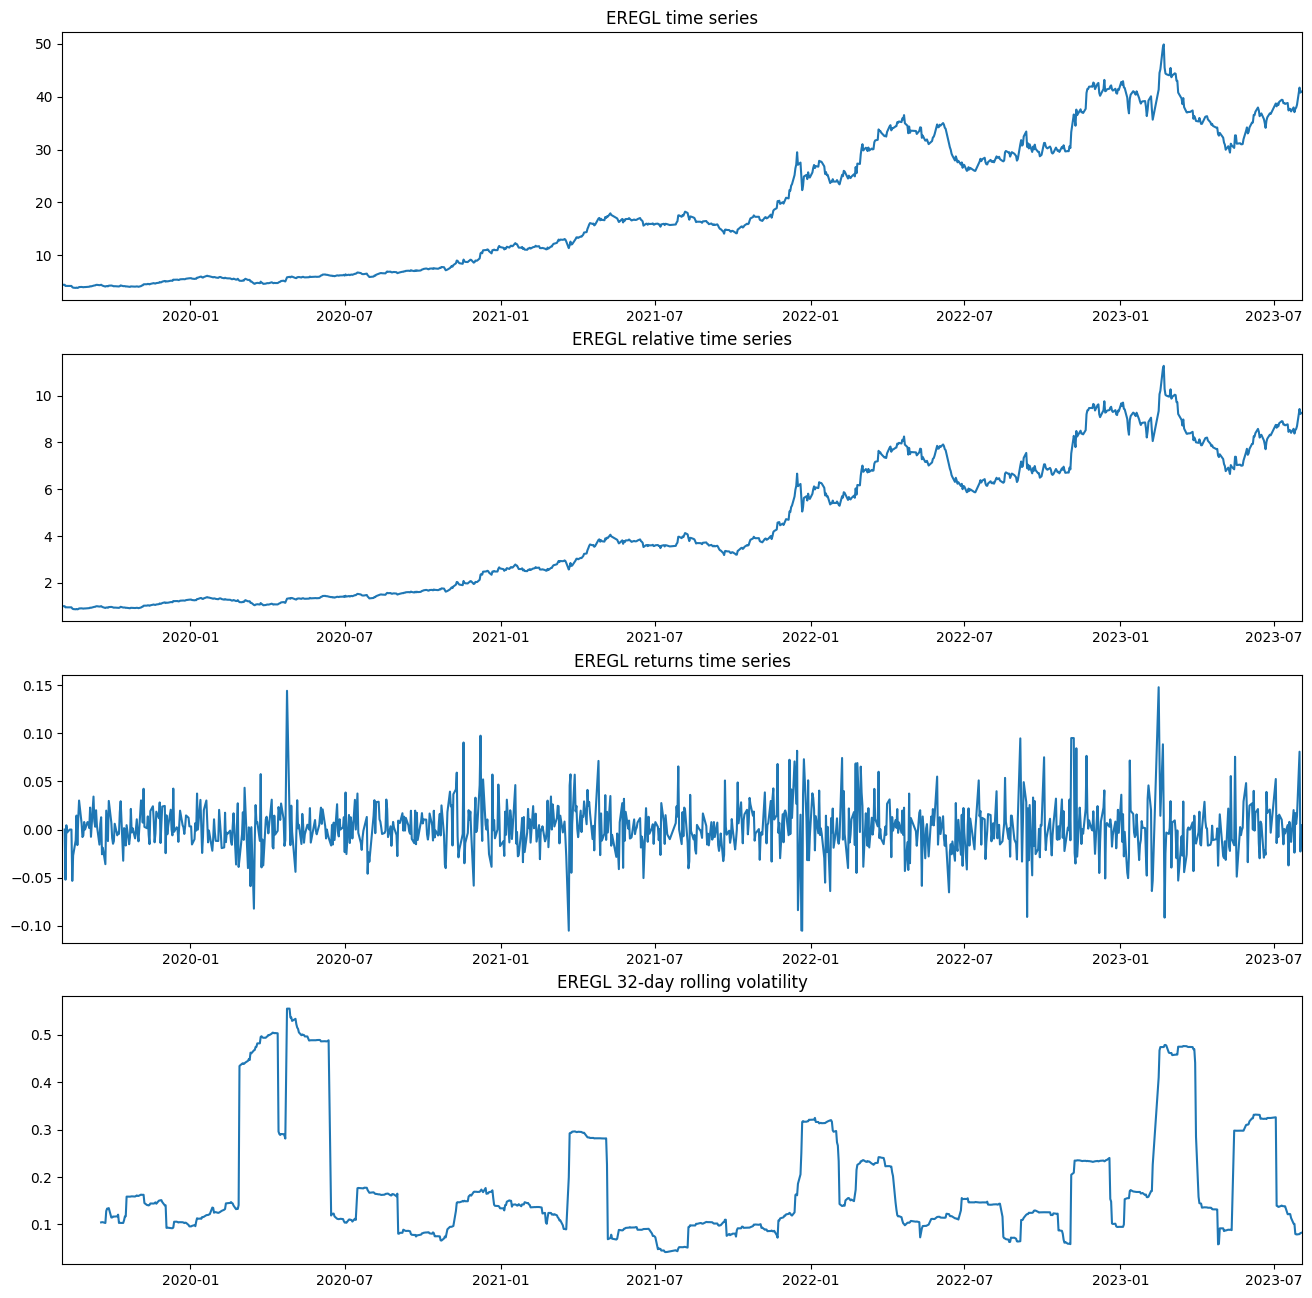

In [296]:
plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series")

plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
plt.plot(data_rel)
plt.title(f"{Ticker} relative time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
plt.plot(data_log_returns)
plt.title(f"{Ticker} returns time series")

plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
data_vlt = data_close.rolling(R_WINDOW).std()*(252**0.5)

plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.plot(data['std']*252**0.5)

fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.show()

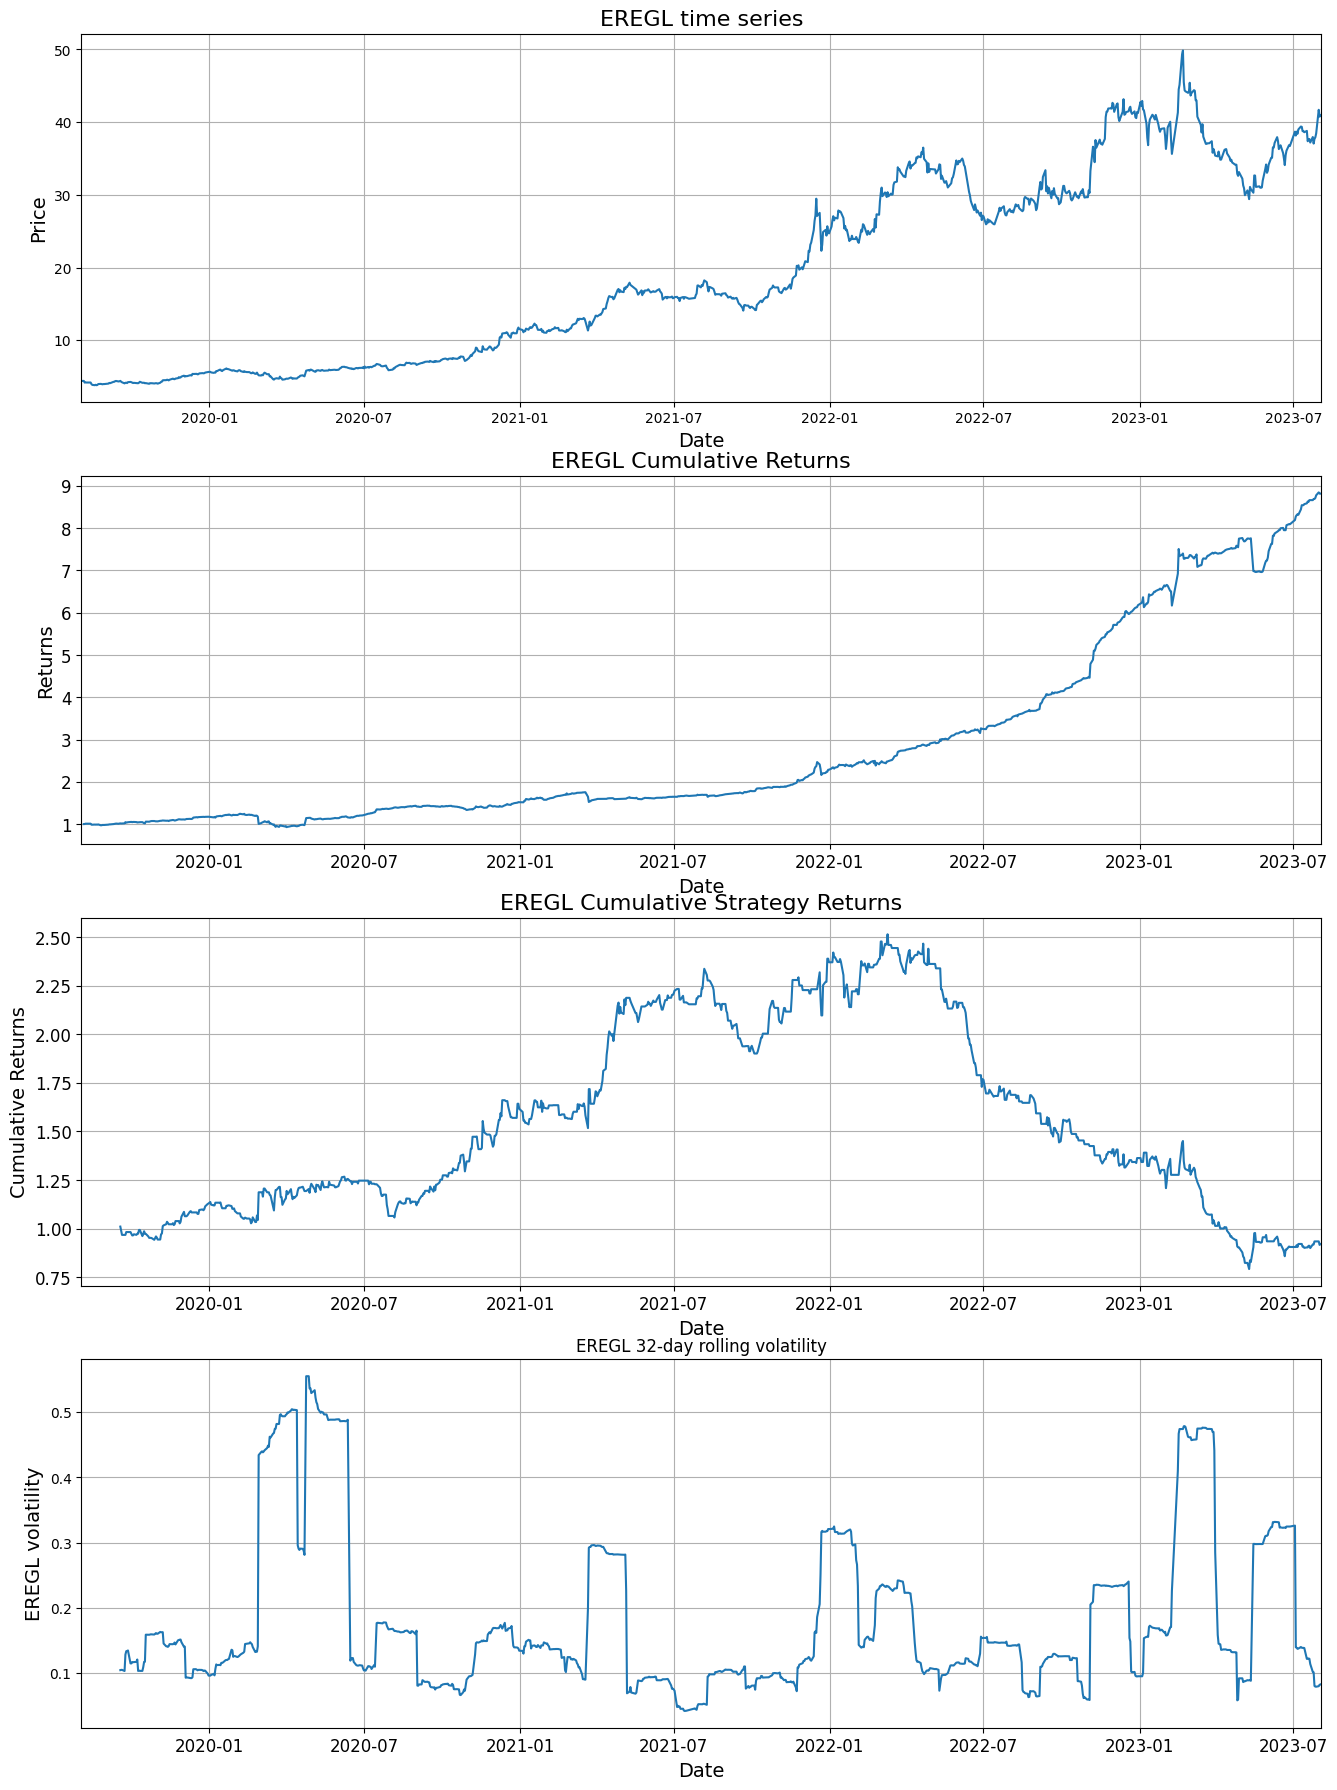

In [297]:
# Plot cumulative returns

import datetime

plt.figure(figsize=(14,11))

plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
data['cumulative_normal_returns'] = (data.returns+1).cumprod()

plt.plot(data.cumulative_normal_returns)
plt.title(f"{Ticker} normal returns")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()


plt.plot(data.cumulative_strategy_returns)
plt.title(f"{Ticker} returns time series")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{Ticker} volatility', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)

plt.plot(data['std']*252**0.5)
fig = plt.gcf()
fig.set_size_inches(16, 22)
plt.show()

In [298]:
data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna()

,Open,High,Low,Close,Adj Close,Volume,Adj Open,returns,std,positions,strategy_returns,cumulative_normal_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,
2019-09-18,7.030000,7.170000,6.980000,7.100000,4.431443,21534112,4.387753,0.002853,0.006573,1.0,0.009957,1.017151,1.009957
2019-09-19,7.080000,7.110000,6.920000,6.920000,4.319097,18641927,4.418960,-0.002817,0.006598,1.0,-0.022599,1.014286,0.987133
2019-09-20,6.930000,6.950000,6.760000,6.790000,4.237958,19564797,4.325338,0.001445,0.006598,1.0,-0.020202,1.015752,0.967191
2019-09-23,6.810000,6.820000,6.540000,6.550000,4.088162,30571159,4.250440,0.002945,0.006491,0.0,-0.000000,1.018744,0.967191
2019-09-24,6.730000,6.780000,6.650000,6.680000,4.169302,38618416,4.200509,0.027481,0.008077,0.0,-0.000000,1.046740,0.967191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,37.799999,38.419998,37.799999,37.919998,37.919998,111668915,37.799999,0.002652,0.004979,0.0,0.000000,8.711893,0.933705
2023-07-28,38.200001,38.720001,38.180000,38.459999,38.459999,133192659,38.200001,0.007384,0.004972,0.0,0.000000,8.776222,0.933705
2023-07-31,38.759998,42.000000,38.759998,41.700001,41.700001,314351426,38.759998,0.007800,0.005021,0.0,0.000000,8.844679,0.933705


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-08-06
End date,2023-08-02
Total months,47
,Backtest
Annual return,73.0%
Cumulative returns,781.5%
Annual volatility,21.6%
Sharpe ratio,2.65
Calmar ratio,2.86
Stability,0.91
Max drawdown,-25.5%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


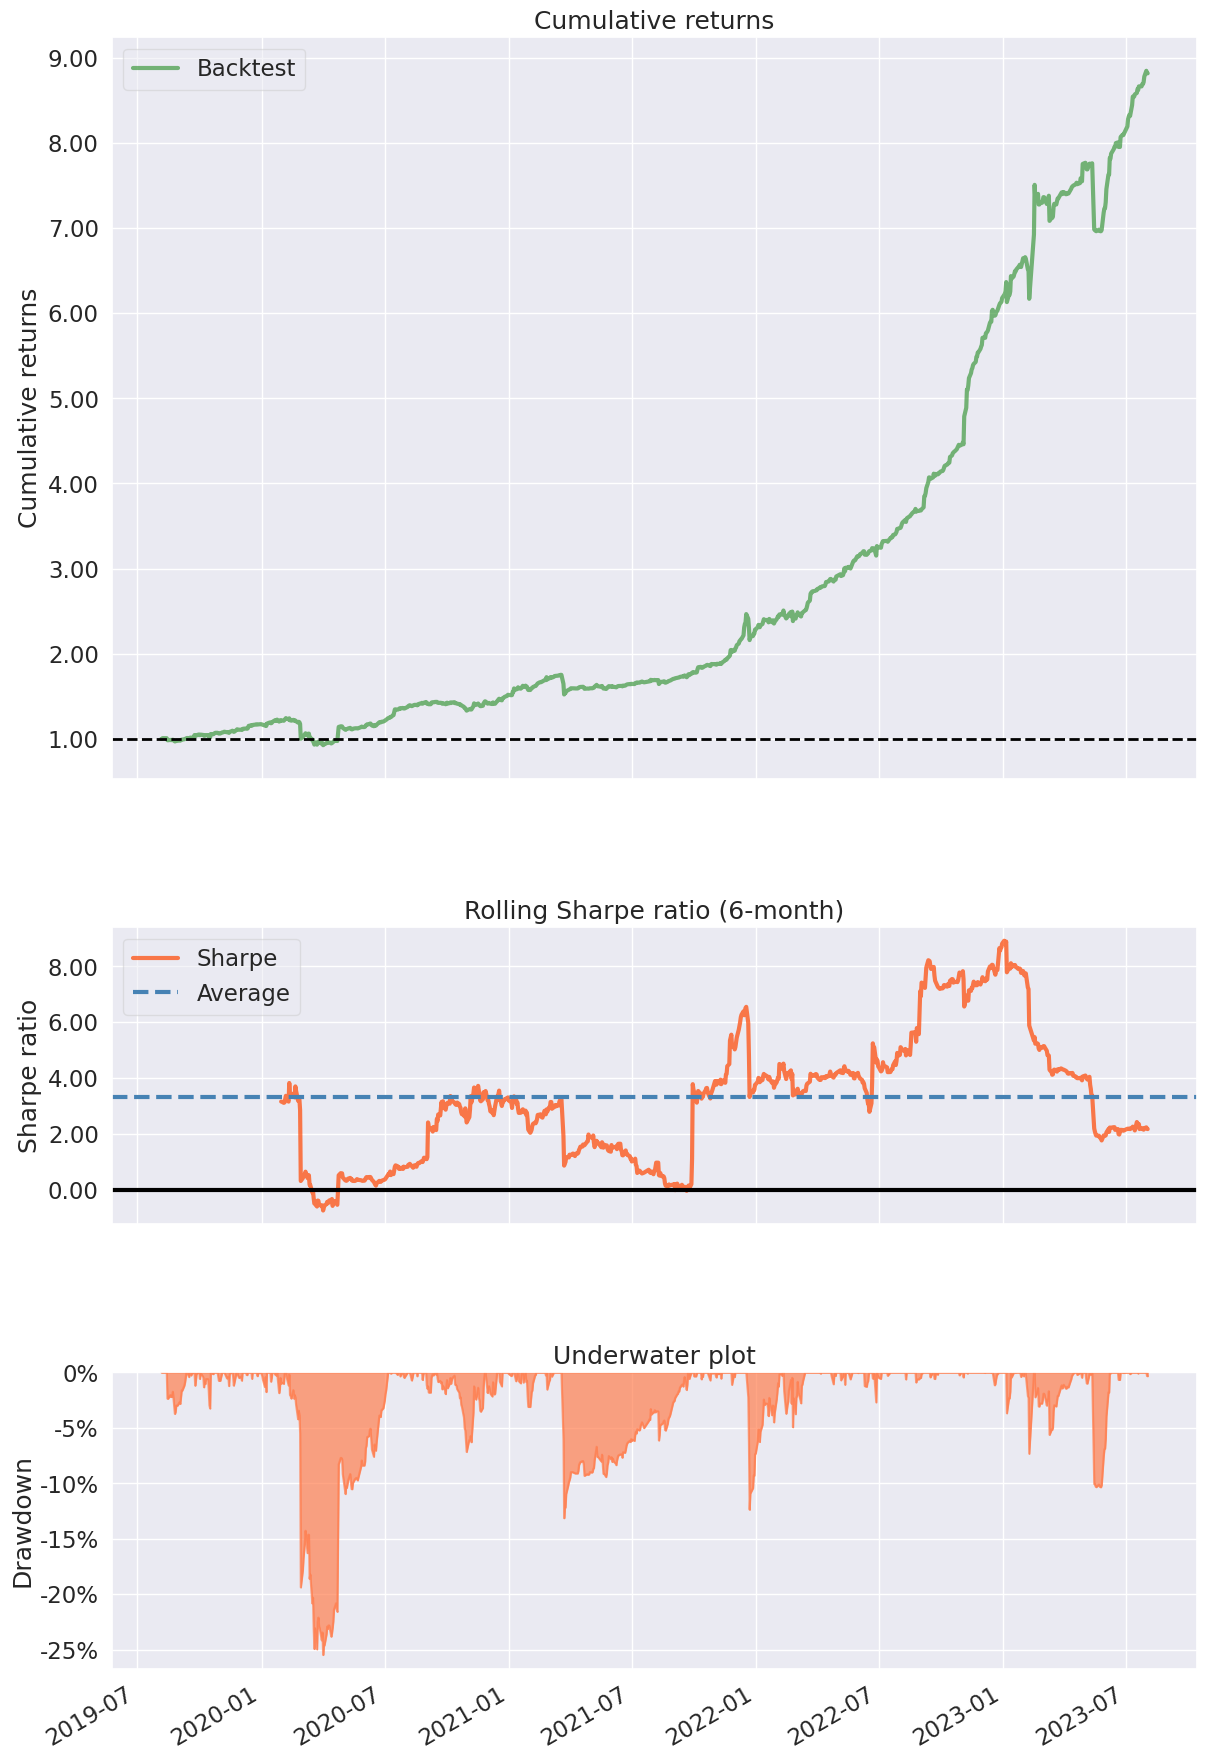

In [299]:
pyf.create_simple_tear_sheet(data.returns.dropna())

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-09-18
End date,2023-08-02
Total months,46
,Backtest
Annual return,-2.1%
Cumulative returns,-8.0%
Annual volatility,29.5%
Sharpe ratio,0.07
Calmar ratio,-0.03
Stability,0.03
Max drawdown,-68.5%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


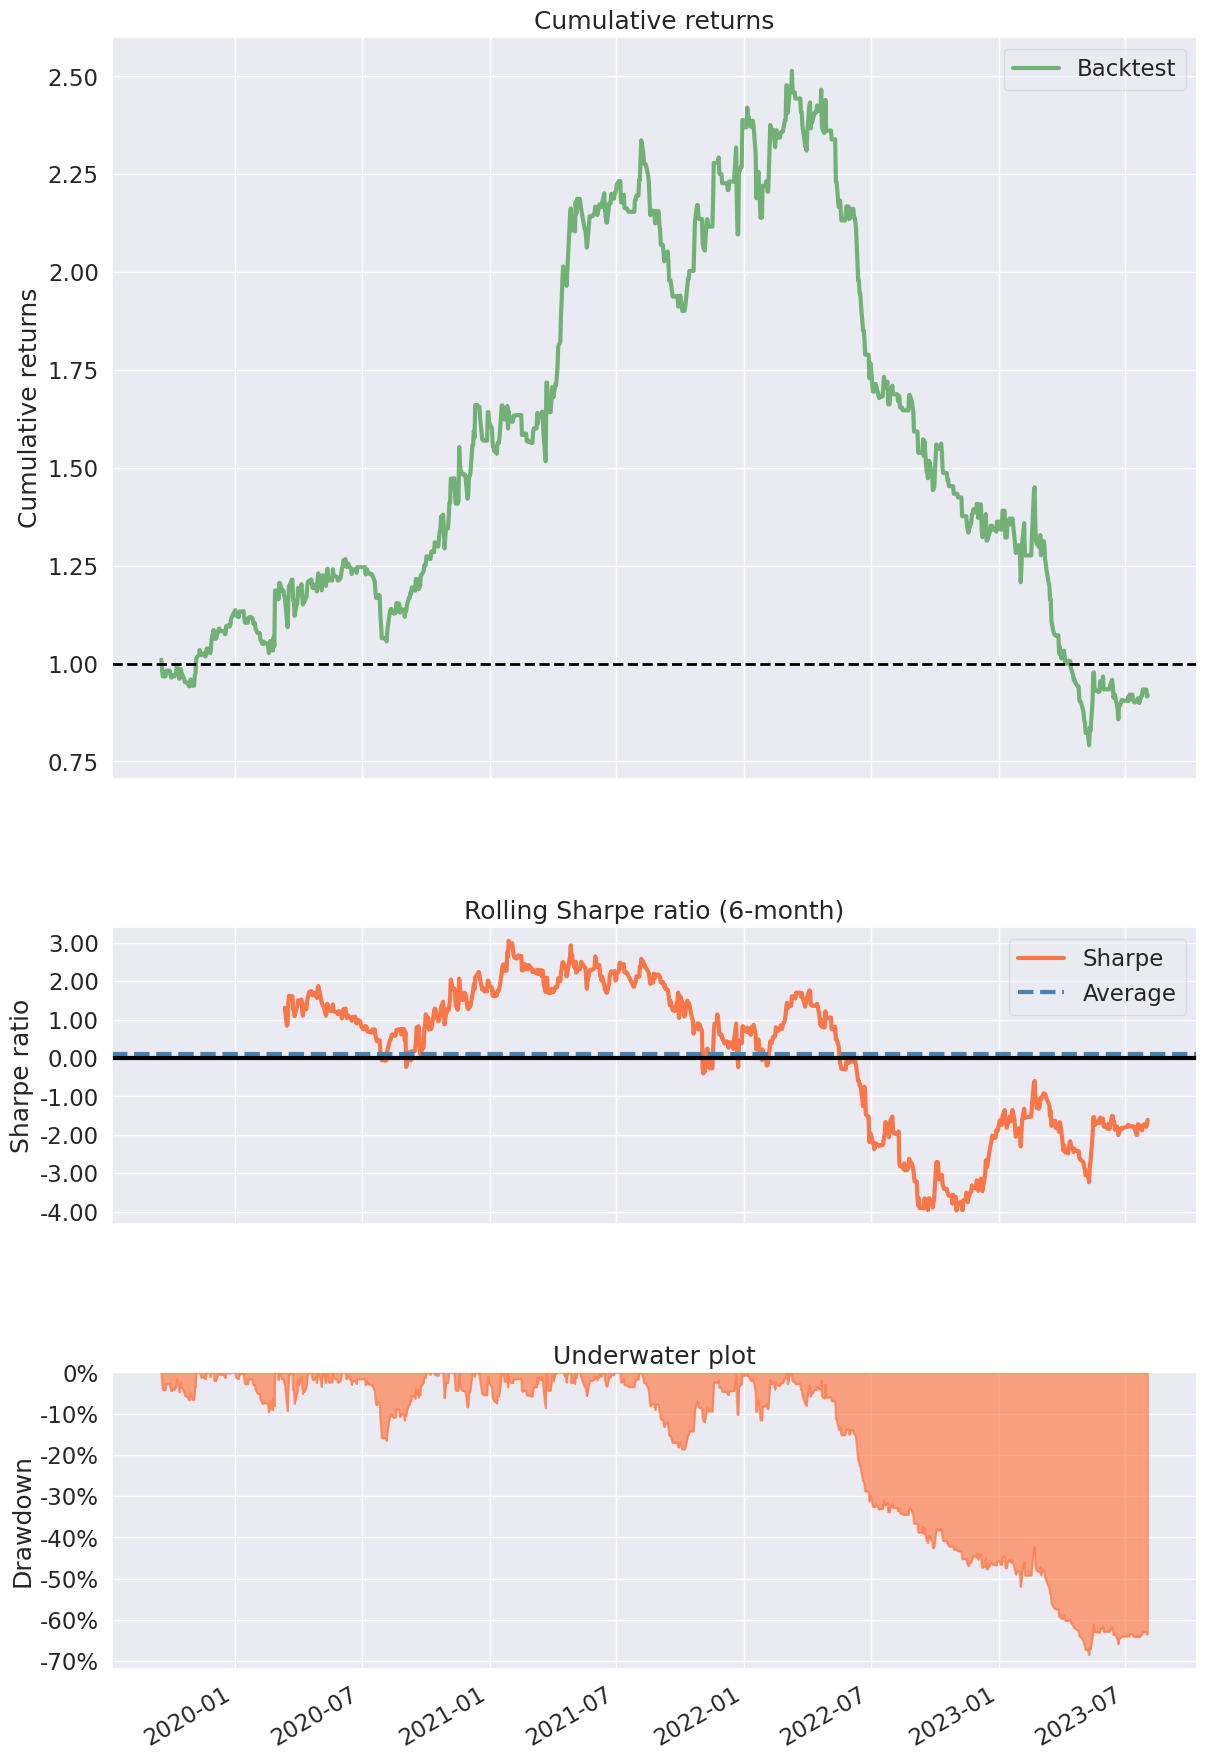

In [300]:
pyf.create_simple_tear_sheet(data.strategy_returns.dropna())

In [301]:
np.max(data.cumulative_normal_returns)

8.844678881403917

In [302]:
(data.cumulative_normal_returns[-1])

8.814984645855283

In [303]:
np.max(data.cumulative_strategy_returns)

2.5141163082908373

In [304]:
(data.cumulative_strategy_returns[-1])

0.9197760018293377

In [305]:
data_rel[-1]

9.25155498392782

In [306]:
data.cumulative_normal_returns[-1]

8.814984645855283

In [307]:
feasible = data.cumulative_normal_returns[-1] / data_rel[-1]

In [308]:
feasible

0.9528111394429407